In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
external_data = pd.read_csv(Path("external_data") / 'external_data.csv')
data = pd.read_parquet(Path("data") / "train.parquet")

In [3]:
print(f'Min date = {external_data["date"].min()}, Max date = {external_data["date"].max()}')

Min date = 2020-09-01 00:00:00, Max date = 2021-10-21 12:00:00


In [4]:
external_data_cleaned = external_data.dropna(axis=1, how='all').sort_values(by='date')

In [5]:
columns_of_interest = ["date", "etat_sol", "dd", "ff", "t", "u", "vv", "n", "ht_neige", "rr3"]

external_data_sorted = external_data_cleaned[columns_of_interest].copy()

external_data_sorted["date"] = pd.to_datetime(external_data_sorted['date'])

# Set temperature to celsius
external_data_sorted.loc[: ,"t"] = external_data_sorted["t"] - 273.15

# Set Lockdown dates
start_date_L1 = '2020-10-30'
end_date_L1 = '2020-12-15'

start_date_L2 = '2021-04-03'
end_date_L2 = '2021-05-04'

external_data_sorted.loc[:, 'Lockdown'] = (
    (external_data_sorted['date'] >= start_date_L1) & (external_data_sorted['date'] < end_date_L1) |
    (external_data_sorted['date'] >= start_date_L2) & (external_data_sorted['date'] < end_date_L2)
).astype(int)

# Set "soft-curfew" dates
start_date_SC1 = '2020-10-17'
end_date_SC1 = '2020-10-30'

start_date_SC2 = '2020-12-15'
end_date_SC2 = '2021-01-16'

start_date_SC3 = '2021-05-19'
end_date_SC3 = '2021-06-21'

external_data_sorted.loc[:, 'soft-curfew'] = (
    (external_data_sorted['date'] >= start_date_SC1) & (external_data_sorted['date'] < end_date_SC1) |
    (external_data_sorted['date'] >= start_date_SC2) & (external_data_sorted['date'] < end_date_SC2) |
    (external_data_sorted['date'] >= start_date_SC3) & (external_data_sorted['date'] < end_date_SC3)
).astype(int)

# Set "hard-curfew" dates
start_date_HC1 = '2021-01-16'
end_date_HC1 = '2021-04-03'

start_date_HC2 = '2021-05-04'
end_date_HC2 = '2021-05-19'

external_data_sorted.loc[:, 'hard-curfew'] = (
    (external_data_sorted['date'] >= start_date_HC1) & (external_data_sorted['date'] < end_date_HC1) |
    (external_data_sorted['date'] >= start_date_HC2) & (external_data_sorted['date'] < end_date_HC2)
).astype(int)

# Set "bank holidays" dates

bank_holidays = pd.to_datetime(['2020-11-01', '2020-11-11', '2020-12-25', '2021-01-01', '2021-04-05',
                 '2021-05-01', '2021-05-13', '2021-05-24', '2021-07-14', '2021-08-15'])

external_data_sorted.loc[:, 'bank_holidays'] = external_data_sorted['date'].isin(bank_holidays).astype(int)

print(external_data_sorted.head())

                    date  etat_sol   dd   ff     t   u     vv     n  ht_neige  \
3082 2020-09-01 00:00:00       0.0  340  1.6  12.6  81  30000   0.0       0.0   
3083 2020-09-01 03:00:00       0.0  290  1.1  10.8  88  25000   0.0       0.0   
3084 2020-09-01 06:00:00       0.0  360  1.8  11.1  91  25000  10.0       0.0   
3085 2020-09-01 09:00:00       0.0  360  2.9  18.1  60  19830  25.0       0.0   
3086 2020-09-01 12:00:00       0.0   40  2.6  20.8  44  21000   NaN       0.0   

      rr3  Lockdown  soft-curfew  hard-curfew  bank_holidays  
3082  0.0         0            0            0              0  
3083  0.0         0            0            0              0  
3084  0.0         0            0            0              0  
3085  0.0         0            0            0              0  
3086  0.0         0            0            0              0  


In [6]:
external_data_sorted.isna().sum()

date               0
etat_sol          52
dd                 0
ff                 0
t                  0
u                  0
vv                 0
n                156
ht_neige          49
rr3                6
Lockdown           0
soft-curfew        0
hard-curfew        0
bank_holidays      0
dtype: int64

In [7]:
# Let's fill missing hours : we will create new lines, which will be copies of the existing lines
def create_missing_hours(row):
    new_rows = []

    # copy = existing line minus two hours
    new_row_2h = row.copy()
    new_row_2h['date'] = row['date'] - pd.Timedelta(hours=2)
    new_rows.append(new_row_2h)

    # copy = existing line minus one hour
    new_row_1h = row.copy()
    new_row_1h['date'] = row['date'] - pd.Timedelta(hours=1)
    new_rows.append(new_row_1h)

    return new_rows

# Appliquer la fonction à chaque ligne du DataFrame
new_rows = []
for index, row in external_data_sorted.iterrows():
    new_rows.extend(create_missing_hours(row))

# Convertir la liste de nouvelles lignes en DataFrame
new_data = pd.DataFrame(new_rows)

# Concaténer les nouvelles lignes avec le DataFrame original
external_data_expanded = pd.concat([external_data_sorted, new_data], ignore_index=True)

# Trier le DataFrame par date
external_data_expanded = external_data_expanded.sort_values(by='date').reset_index(drop=True)

# Afficher les premières lignes du DataFrame modifié
print(external_data_expanded.head())

                 date  etat_sol   dd   ff     t   u     vv    n  ht_neige  \
0 2020-08-31 22:00:00       0.0  340  1.6  12.6  81  30000  0.0       0.0   
1 2020-08-31 23:00:00       0.0  340  1.6  12.6  81  30000  0.0       0.0   
2 2020-09-01 00:00:00       0.0  340  1.6  12.6  81  30000  0.0       0.0   
3 2020-09-01 01:00:00       0.0  290  1.1  10.8  88  25000  0.0       0.0   
4 2020-09-01 02:00:00       0.0  290  1.1  10.8  88  25000  0.0       0.0   

   rr3  Lockdown  soft-curfew  hard-curfew  bank_holidays  
0  0.0         0            0            0              0  
1  0.0         0            0            0              0  
2  0.0         0            0            0              0  
3  0.0         0            0            0              0  
4  0.0         0            0            0              0  


external_data_expanded = external_data_expanded.dropna(axis=0)

In [8]:
data_train = pd.merge(data, external_data_expanded, on='date', how='inner')

In [9]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    return X.drop(columns=["date"])

external_data_train = _encode_dates(data_train)
external_data_train.head()

,counter_id,counter_name,site_id,site_name,bike_count,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,...,rr3,Lockdown,soft-curfew,hard-curfew,bank_holidays,year,month,day,weekday,hour
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,...,0.0,0,0,0,0,2020,9,1,1,2
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,...,0.0,0,0,0,0,2020,9,1,1,3
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,...,0.0,0,0,0,0,2020,9,1,1,4
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,...,0.0,0,0,0,0,2020,9,1,1,15
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,...,0.0,0,0,0,0,2020,9,1,1,18


In [10]:
y = external_data_train["log_bike_count"]
X = external_data_train.drop(
    columns=["log_bike_count", "bike_count", "site_id", "counter_name", "site_name",
             "coordinates", "counter_technical_id", "latitude", "longitude"])

In [11]:
X = pd.get_dummies(X, columns=["counter_id"], dummy_na=True, drop_first=True, prefix_sep=' ')
X.drop(columns=["counter_installation_date", "counter_id nan"], inplace=True)

In [12]:
X.head()

,etat_sol,dd,ff,t,u,vv,n,ht_neige,rr3,Lockdown,...,counter_id 100057380-103057380,counter_id 100057380-104057380,counter_id 100057445-103057445,counter_id 100057445-104057445,counter_id 100060178-101060178,counter_id 100060178-102060178,counter_id 100063175-353277233,counter_id 100063175-353277235,counter_id 300014702-353245971,counter_id 300014702-353245972
0,0.0,290,1.1,10.8,88,25000,0.0,0.0,0.0,0,...,False,False,False,False,False,False,False,False,False,False
1,0.0,290,1.1,10.8,88,25000,0.0,0.0,0.0,0,...,False,False,False,False,False,False,False,False,False,False
2,0.0,360,1.8,11.1,91,25000,10.0,0.0,0.0,0,...,False,False,False,False,False,False,False,False,False,False
3,0.0,40,4.0,20.5,41,30000,60.0,0.0,0.0,0,...,False,False,False,False,False,False,False,False,False,False
4,0.0,20,3.0,19.0,47,30000,90.0,0.0,0.0,0,...,False,False,False,False,False,False,False,False,False,False


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor(random_state=0)
regr.fit(X_train, y_train)

regr.score(X_test, y_test)

0.8820252740740141

In [15]:
import xgboost as xgb
from sklearn.metrics import r2_score

# Initialiser le modèle XGBoost
boost = xgb.XGBRegressor(random_state=0)

# Entraîner le modèle
boost.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = boost.predict(X_test)

# Calculer le score R²
score = r2_score(y_test, y_pred)
print("R² Score:", score)

R² Score: 0.9247632118617227


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), DecisionTreeRegressor())
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8829576566790991

In [17]:
model_2 = make_pipeline(StandardScaler(), xgb.XGBRegressor(random_state=0))
model_2.fit(X_train, y_train)

y_pred = model_2.predict(X_test)

# Calculer le score R²
score = r2_score(y_test, y_pred)
print("R² Score:", score)

R² Score: 0.9247632118617227


In [18]:
from sklearn.metrics import root_mean_squared_error

print(f"Train set, RMSE={root_mean_squared_error(y_train, regr.predict(X_train)):.2f}")
print(f"Test set, RMSE={root_mean_squared_error(y_test, regr.predict(X_test)):.2f}")

print(f"Train set, RMSE={root_mean_squared_error(y_train, model.predict(X_train)):.2f}")
print(f"Test set, RMSE={root_mean_squared_error(y_test, model.predict(X_test)):.2f}")

print(f"Train set, RMSE={root_mean_squared_error(y_train, boost.predict(X_train)):.2f}")
print(f"Test set, RMSE={root_mean_squared_error(y_test, boost.predict(X_test)):.2f}")

print(f"Train set, RMSE={root_mean_squared_error(y_train, model_2.predict(X_train)):.2f}")
print(f"Test set, RMSE={root_mean_squared_error(y_test, model_2.predict(X_test)):.2f}")

Train set, RMSE=0.02
Test set, RMSE=0.57
Train set, RMSE=0.02
Test set, RMSE=0.57
Train set, RMSE=0.44
Test set, RMSE=0.46
Train set, RMSE=0.44
Test set, RMSE=0.46


In [19]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(regr, X_train, y_train, train_sizes=np.linspace(0.2, 1, 5), cv=5)

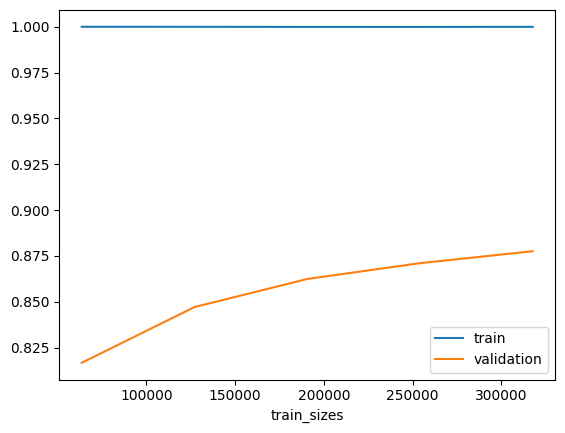

In [20]:
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()